<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/etc/MainQuest4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 신용카드 사기 검출 - 실전 수준 불균형 분류 파이프라인 (개선판)
# 기능 요약:
#  - 데이터 불러오기 및 EDA(클래스 분포, 상관관계, PCA)
#  - 전처리: 표준화(Scaler) 및 선택적 파생변수(예시는 주석처리)
#  - 불균형 대응: class_weight, SMOTE/RandomOver/Under, XGBoost scale_pos_weight
#  - 모델: LogisticRegression(L1/L2 - Lasso/Ridge), XGBoost, LightGBM
#  - 하이퍼파라미터 튜닝: RandomizedSearchCV (평가 지표: PR-AUC / average_precision)
#  - 앙상블: Soft Voting, Stacking
#  - 임계값(Threshold) 탐색: PR-curve 기반 최적 임계값 찾기(예: F1 최대화 또는 recall 균형)
#  - 출력 해석: 각 단계별 지표 및 간단 해석 안내

# 주의: Kaggle 환경에서 실행한다고 가정합니다. 필요한 패키지는 설치하세요.
# 예: !pip install -q xgboost==1.5.0 lightgbm==3.3.2 imbalanced-learn

# ------------------------------
# 라이브러리 import
# ------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score, precision_recall_curve)
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.base import clone

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
import lightgbm as lgb

In [ ]:
# ------------------------------
# 유틸리티 함수
# ------------------------------

def print_metrics(y_true, y_pred, y_proba=None, prefix=''):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{prefix}혼동행렬:{cm}")
    print(f"{prefix}정확도: {acc:.4f}, 정밀도: {prec:.4f}, 재현율: {rec:.4f}, F1: {f1:.4f}")
    if y_proba is not None:
        roc = roc_auc_score(y_true, y_proba)
        pr = average_precision_score(y_true, y_proba)
        print(f"{prefix}ROC-AUC: {roc:.4f}, PR-AUC(AP): {pr:.4f}")
    print('---')


def plot_class_distribution(y, title='Class distribution'):
    counts = pd.Series(y).value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, v in enumerate(counts.values):
        plt.text(i, v + max(counts.values)*0.01, str(v), ha='center')
    plt.show()


def plot_pca_2d(X, y, title='PCA 2D'):
    pca = PCA(n_components=2)
    Xp = pca.fit_transform(X)
    df = pd.DataFrame({'PC1': Xp[:,0], 'PC2': Xp[:,1], 'Class': y.values if hasattr(y, 'values') else y})
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Class', alpha=0.6, s=30)
    plt.title(f"{title} (explained: {pca.explained_variance_ratio_.sum():.2f})")
    plt.show()


def threshold_search(y_true, y_proba, metric='f1'):
    """임계값을 바꿔가며 metric이 최대가 되는 threshold를 찾는다.
    metric: 'f1' 또는 'recall_at_precision' (precision >= 0.9 시의 recall)
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_thresh_f1 = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    # precision constraint 예시
    prec_target = 0.90
    eligible = np.where(precisions >= prec_target)[0]
    if len(eligible) > 0:
        # 해당 precision에서 recall 중 최대값을 취함
        recall_at_prec = recalls[eligible]
        idx = eligible[np.argmax(recall_at_prec)]
        thresh_rec_at_prec = thresholds[idx] if idx < len(thresholds) else 0.5
    else:
        thresh_rec_at_prec = None

    return {
        'best_f1_threshold': best_thresh_f1,
        'best_f1': f1s[best_idx],
        'precision': precisions[best_idx],
        'recall': recalls[best_idx],
        'threshold_for_precision_0.90': thresh_rec_at_prec
    }

In [ ]:
# ------------------------------
# 1) 데이터 로드 및 기본 확인
# ------------------------------
train_path = './train.csv'
test_path  = './test.csv'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError('train.csv 또는 test.csv를 현재 작업 디렉토리에서 찾을 수 없습니다.')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print('train shape:', train_df.shape)
print('test shape:', test_df.shape)

train shape: (35369, 32)
test shape: (31342, 31)


[타깃 분포]


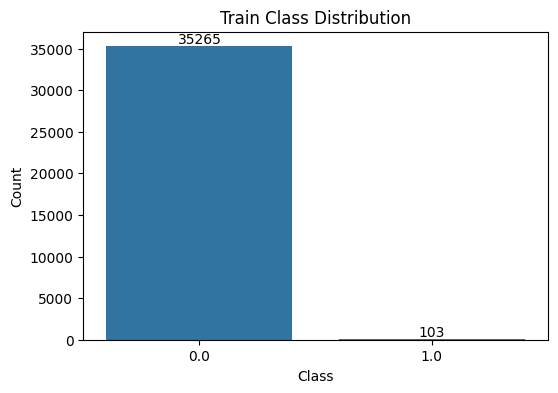

[기초 통계 요약]
          count          mean           std        min           25%  \
id      35369.0  17684.000000  10210.295172   0.000000   8842.000000   
Time    35369.0  23847.855608  12403.015137   0.000000  12093.000000   
V1      35369.0     -0.208800      1.839569 -30.552380     -0.959509   
V2      35369.0      0.074838      1.542441 -40.978852     -0.496756   
V3      35369.0      0.717403      1.545783 -31.103685      0.244230   
V4      35369.0      0.196880      1.410475  -5.172595     -0.714182   
V5      35369.0     -0.216055      1.391718 -42.147898     -0.815580   
V6      35369.0      0.096323      1.312081 -23.496714     -0.645362   
V7      35369.0     -0.117267      1.261313 -26.548144     -0.597805   
V8      35369.0      0.032040      1.246693 -41.484823     -0.155787   
V9      35369.0      0.264506      1.240124  -7.175097     -0.521349   
V10     35369.0     -0.087752      1.140141 -14.166795     -0.567149   
V11     35369.0      0.459240      1.138040  -2.98530

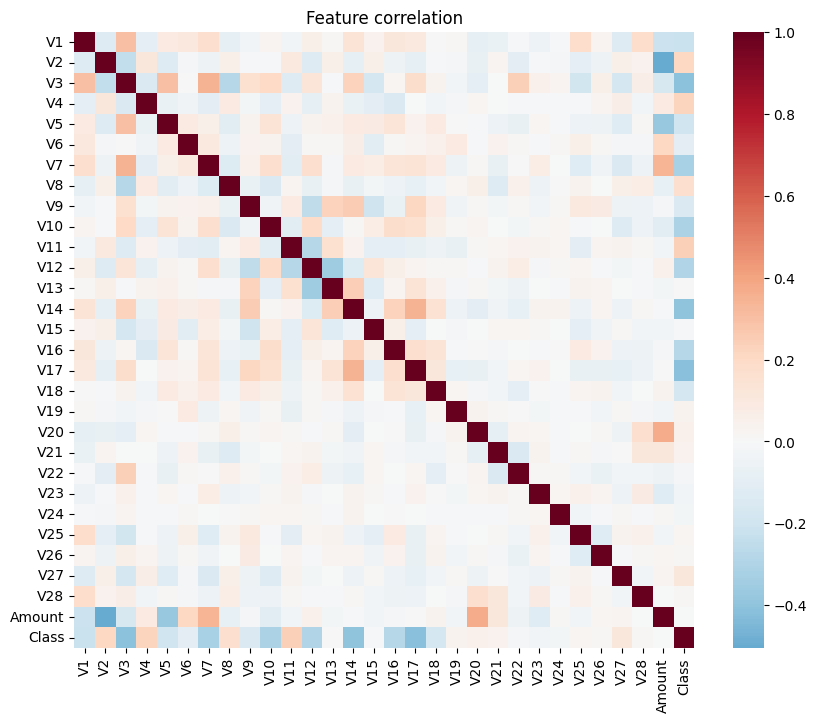

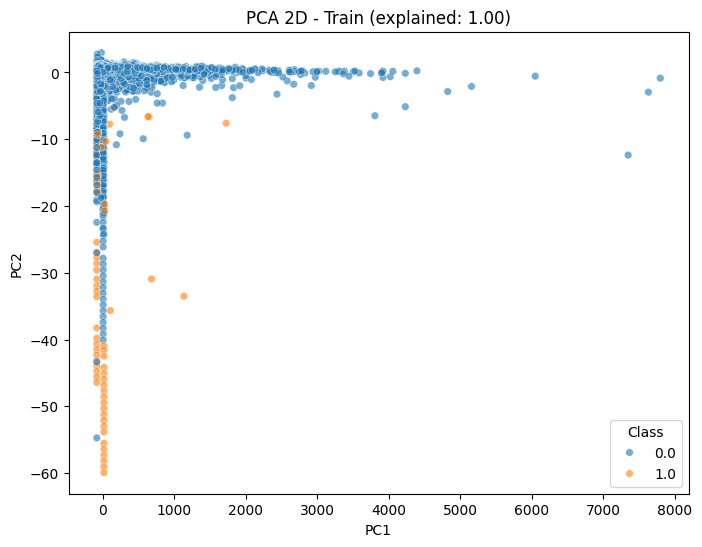

In [ ]:
# ------------------------------
# 2) 간단 EDA: 분포, 통계, 상관관계, PCA
# ------------------------------
print('[타깃 분포]')
plot_class_distribution(train_df['Class'], title='Train Class Distribution')

print('[기초 통계 요약]')
print(train_df.describe().T)

# Time 컬럼은 예시로 제거
if 'Time' in train_df.columns:
    train_df = train_df.drop('Time', axis=1)
if 'Time' in test_df.columns:
    test_df = test_df.drop('Time', axis=1)

# 결측치 처리: 수치형은 중앙값으로 대체
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# 결측치 처리하기 전에 train_df와 test_df의 컬럼 구조를 같게 한 후 imputer를 fit/transform하기
# 타깃(Class) 컬럼은 제외하고 결측치 대체 (train_df에는 Class 컬럼이 있고, test_df에는 없다)
# 타깃 예측에 의미 없는 정보인 id도 제거
imputer.fit(train_df.drop(['Class','id'], axis=1, errors='ignore'))

# train/test 모두 동일한 방식으로 결측치 대체
X_train_imputed = pd.DataFrame(imputer.transform(train_df.drop(['Class','id'], axis=1, errors='ignore')), columns=[c for c in train_df.columns if c not in ['Class', 'id']])
X_test_imputed = pd.DataFrame(imputer.transform(test_df.drop(['id'], axis=1, errors='ignore')), columns=[c for c in test_df.columns if c != 'id'])

# 다시 Class 붙이기
train_df_imputed = pd.concat([X_train_imputed, train_df['Class'].reset_index(drop=True)], axis=1)

# 상관관계 히트맵 (작을수록 시각화 속도 향상)
plt.figure(figsize=(10,8))
sns.heatmap(train_df_imputed.corr(), cmap='RdBu_r', center=0)
plt.title('Feature correlation')
plt.show()

# X,y 분리
X = train_df_imputed.drop('Class', axis=1)
y = train_df_imputed['Class']
plot_pca_2d(X, y, title='PCA 2D - Train')


In [ ]:
# ------------------------------
# 3) train/val 분리 (stratify)
# ------------------------------
# 결측값이 있는 타깃 행 제거
train_df_imputed = train_df_imputed.dropna(subset=['Class']).reset_index(drop=True)

# 다시 X, y 분리
X = train_df_imputed.drop(['Class','id'], axis=1, errors='ignore')
y = train_df_imputed['Class']

# split을 수행
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Train positive ratio: {:.6f}'.format(y_train.mean()))
print('Val positive ratio: {:.6f}'.format(y_val.mean()))

Train positive ratio: 0.002898
Val positive ratio: 0.002969


In [ ]:
# ------------------------------
# 4) 모델 및 파라미터 공간 정의
# ------------------------------
scaler = StandardScaler()
# Logistic: L1(Lasso) / L2(Ridge) 제약 실험을 위해 saga solver 사용
lr = LogisticRegression(max_iter=5000, solver='saga')

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_clf = lgb.LGBMClassifier(random_state=42)

# sampling 옵션
samplers = {
    'none': None,
    'smote': SMOTE(random_state=42),
    'over': RandomOverSampler(random_state=42),
    'under': RandomUnderSampler(random_state=42)
}

# 파라미터 공간 (간단히 예시)
lr_param_dist = {
    'clf__penalty': ['l1','l2'],
    'clf__C': np.logspace(-3, 2, 20)
}

xgb_param_dist = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [3,5,7],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__subsample': [0.6,0.8,1.0],
    'clf__colsample_bytree': [0.6,0.8,1.0]
}

lgb_param_dist = {
    'clf__n_estimators': [50,100,200],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__num_leaves': [15,31,63],
    'clf__max_depth': [-1,5,7]
}

In [ ]:
# ------------------------------
# 5) 모델 학습/튜닝 함수
# ------------------------------

def tune_and_fit(model, param_dist, sampler=None, n_iter=20, random_state=42):
    """샘플러가 있으면 imblearn 파이프라인 사용, 없으면 sklearn Pipeline 사용"""
    if sampler is None:
        pipe = Pipeline([('scaler', scaler), ('clf', model)])
    else:
        pipe = ImbPipeline([('scaler', scaler), ('sampler', sampler), ('clf', model)])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter,
                            scoring='average_precision', cv=skf, n_jobs=-1, verbose=0, random_state=random_state, refit=True)
    rs.fit(X_train, y_train)
    print(f"== {type(model).__name__} best params ==")
    print(rs.best_params_)
    print('Best CV PR-AUC:', rs.best_score_)

    # 검증 성능
    y_pred = rs.predict(X_val)
    try:
        y_proba = rs.predict_proba(X_val)[:,1]
    except Exception:
        try:
            y_proba = rs.decision_function(X_val)
        except Exception:
            y_proba = None
    print_metrics(y_val, y_pred, y_proba, prefix=f'[{type(model).__name__}] ')
    return rs

In [ ]:
# ------------------------------
# 6) 모델별 학습 (샘플링 전략 포함) - 예시로 몇 가지 조합만 실행
# ------------------------------
results = {}

# A: LogisticRegression + SMOTE
print('>>> LogisticRegression + SMOTE 튜닝 및 학습')
results['lr_smote'] = tune_and_fit(clone(lr), lr_param_dist, sampler=SMOTE(random_state=42), n_iter=20)

# B: XGBoost - no sampler, but scale_pos_weight 사용 (불균형 보정)
print('>>> XGBoost (scale_pos_weight) 튜닝 및 학습')
pos = y_train.sum()
neg = y_train.shape[0] - pos
scale_pos_weight = neg / pos if pos > 0 else 1
print('scale_pos_weight:', scale_pos_weight)
# XGBoost 파라미터에 scale_pos_weight 고정값 포함
xgb_param_with_spw = xgb_param_dist.copy()
xgb_param_with_spw['clf__scale_pos_weight'] = [scale_pos_weight]
results['xgb_spw'] = tune_and_fit(clone(xgb_clf), xgb_param_with_spw, sampler=None, n_iter=20)

# C: LightGBM + SMOTE
print('>>> LightGBM + SMOTE 튜닝 및 학습')
results['lgb_smote'] = tune_and_fit(clone(lgb_clf), lgb_param_dist, sampler=SMOTE(random_state=42), n_iter=20)

>>> LogisticRegression + SMOTE 튜닝 및 학습
== LogisticRegression best params ==
{'clf__penalty': 'l1', 'clf__C': np.float64(0.001)}
Best CV PR-AUC: 0.7001080838588374
[LogisticRegression] 혼동행렬:[[6957   96]
 [   1   20]]
[LogisticRegression] 정확도: 0.9863, 정밀도: 0.1724, 재현율: 0.9524, F1: 0.2920
[LogisticRegression] ROC-AUC: 0.9919, PR-AUC(AP): 0.6374
---
>>> XGBoost (scale_pos_weight) 튜닝 및 학습
scale_pos_weight: 344.0487804878049
== XGBClassifier best params ==
{'clf__subsample': 0.8, 'clf__scale_pos_weight': np.float64(344.0487804878049), 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}
Best CV PR-AUC: 0.9238754440119665
[XGBClassifier] 혼동행렬:[[7052    1]
 [   2   19]]
[XGBClassifier] 정확도: 0.9996, 정밀도: 0.9500, 재현율: 0.9048, F1: 0.9268
[XGBClassifier] ROC-AUC: 0.9959, PR-AUC(AP): 0.9445
---
>>> LightGBM + SMOTE 튜닝 및 학습
[LightGBM] [Info] Number of positive: 28212, number of negative: 28212
[LightGBM] [Info] Auto-choosing col-wise multi-threading

Top 10 feature importances for xgb_spw:
V4        0.436131
V14       0.327711
V12       0.060431
V3        0.023440
V19       0.018989
V7        0.018612
V11       0.018040
Amount    0.016488
V17       0.015309
V26       0.008773
dtype: float32


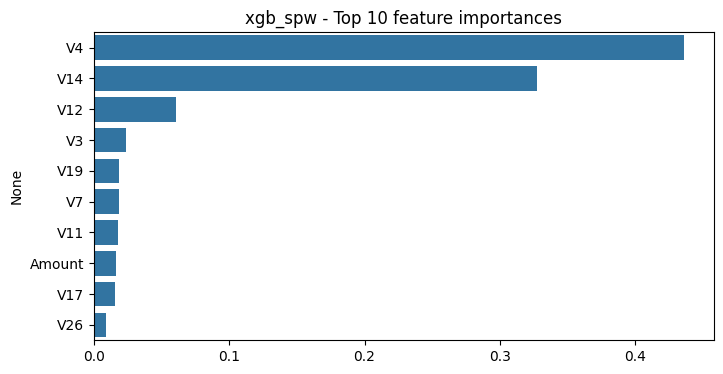

Top 10 feature importances for lgb_smote:
V26    440
V4     351
V12    344
V14    341
V6     242
V13    227
V17    225
V11    204
V19    198
V5     183
dtype: int32


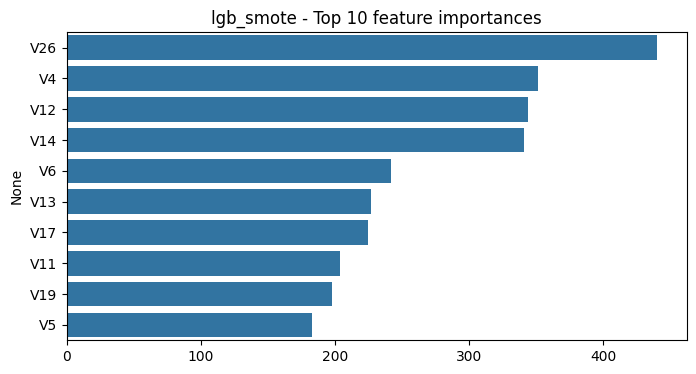

In [ ]:
# ------------------------------
# 7) Feature importance (트리 기반)
# ------------------------------
for key in ['xgb_spw', 'lgb_smote']:
    est = results[key].best_estimator_
    clf = est.named_steps['clf']
    try:
        importances = clf.feature_importances_
        fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
        print(f"Top 10 feature importances for {key}:")
        print(fi.head(10))
        plt.figure(figsize=(8,4))
        sns.barplot(x=fi.head(10).values, y=fi.head(10).index)
        plt.title(f"{key} - Top 10 feature importances")
        plt.show()
    except Exception:
        print(f"{key}에서 feature_importances_를 얻을 수 없습니다.")

In [ ]:
# ------------------------------
# 8) 앙상블: Voting 및 Stacking
# ------------------------------
print('>>> Soft Voting Ensemble')
vc_estimators = [('lr', results['lr_smote'].best_estimator_), ('xgb', results['xgb_spw'].best_estimator_), ('lgb', results['lgb_smote'].best_estimator_)]
voting = VotingClassifier(estimators=vc_estimators, voting='soft', n_jobs=-1)
# Voting 내부에서 pipeline 객체를 래핑하므로 바로 fit 가능
voting.fit(X_train, y_train)
try:
    y_val_proba_v = voting.predict_proba(X_val)[:,1]
except Exception:
    y_val_proba_v = None
y_val_pred_v = voting.predict(X_val)
print_metrics(y_val, y_val_pred_v, y_val_proba_v, prefix='[Voting] ')

print('>>> Stacking Ensemble')
stack_estimators = [('lr', results['lr_smote'].best_estimator_), ('xgb', results['xgb_spw'].best_estimator_), ('lgb', results['lgb_smote'].best_estimator_)]
stack = StackingClassifier(estimators=stack_estimators, final_estimator=LogisticRegression(max_iter=2000), n_jobs=-1)
stack.fit(X_train, y_train)
try:
    y_val_proba_s = stack.predict_proba(X_val)[:,1]
except Exception:
    y_val_proba_s = None
y_val_pred_s = stack.predict(X_val)
print_metrics(y_val, y_val_pred_s, y_val_proba_s, prefix='[Stacking] ')

>>> Soft Voting Ensemble
[Voting] 혼동행렬:[[7050    3]
 [   1   20]]
[Voting] 정확도: 0.9994, 정밀도: 0.8696, 재현율: 0.9524, F1: 0.9091
[Voting] ROC-AUC: 0.9930, PR-AUC(AP): 0.9487
---
>>> Stacking Ensemble
[Stacking] 혼동행렬:[[7052    1]
 [   2   19]]
[Stacking] 정확도: 0.9996, 정밀도: 0.9500, 재현율: 0.9048, F1: 0.9268
[Stacking] ROC-AUC: 0.9930, PR-AUC(AP): 0.9487
---


In [ ]:
# ------------------------------
# 9) 모델 비교 표
# ------------------------------
summary = []
models_to_eval = [('lr_smote', results['lr_smote']), ('xgb_spw', results['xgb_spw']), ('lgb_smote', results['lgb_smote']), ('voting', voting), ('stack', stack)]
for name, obj in models_to_eval:
    if isinstance(obj, (VotingClassifier, StackingClassifier)):
        clf = obj
    else:
        clf = obj.best_estimator_
    pred = clf.predict(X_val)
    try:
        proba = clf.predict_proba(X_val)[:,1]
    except Exception:
        try:
            proba = clf.decision_function(X_val)
        except Exception:
            proba = None
    acc = accuracy_score(y_val, pred)
    prec = precision_score(y_val, pred, zero_division=0)
    rec = recall_score(y_val, pred, zero_division=0)
    f1 = f1_score(y_val, pred, zero_division=0)
    roc = roc_auc_score(y_val, proba) if proba is not None else np.nan
    pr = average_precision_score(y_val, proba) if proba is not None else np.nan
    summary.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc, 'pr_auc': pr})

summary_df = pd.DataFrame(summary).sort_values(by='pr_auc', ascending=False)
print('=== 모델 비교 (Val set) ===')
print(summary_df)

=== 모델 비교 (Val set) ===
       model  accuracy  precision    recall        f1   roc_auc    pr_auc
4      stack  0.999576   0.950000  0.904762  0.926829  0.992951  0.948673
3     voting  0.999435   0.869565  0.952381  0.909091  0.992951  0.948673
1    xgb_spw  0.999576   0.950000  0.904762  0.926829  0.995909  0.944465
2  lgb_smote  0.998869   0.760000  0.904762  0.826087  0.990237  0.934228
0   lr_smote  0.986288   0.172414  0.952381  0.291971  0.991945  0.637387


In [ ]:
# ------------------------------
# 10) 임계값 탐색 예시 (VotingClassifier 확률 기준)
# ------------------------------
print('>>> Threshold search (VotingClassifier)')
try:
    voting_proba = voting.predict_proba(X_val)[:,1]
    ts = threshold_search(y_val, voting_proba, metric='f1')
    print('Best F1 threshold:', ts['best_f1_threshold'])
    print('Best F1:', ts['best_f1'])
    print('Precision at best F1:', ts['precision'])
    print('Recall at best F1:', ts['recall'])
    print('Threshold for precision >= 0.90:', ts['threshold_for_precision_0.90'])

    # 예시: 임계값을 best_f1_threshold로 설정하여 성능 재계산
    thr = ts['best_f1_threshold']
    val_pred_thr = (voting_proba >= thr).astype(int)
    print_metrics(y_val, val_pred_thr, voting_proba, prefix='[Voting - thr adjusted] ')
except Exception as e:
    print('Threshold search 실패:', e)

>>> Threshold search (VotingClassifier)
Best F1 threshold: 0.7191857235716963
Best F1: 0.9523809523804523
Precision at best F1: 0.9523809523809523
Recall at best F1: 0.9523809523809523
Threshold for precision >= 0.90: 0.5881691196574166
[Voting - thr adjusted] 혼동행렬:[[7052    1]
 [   1   20]]
[Voting - thr adjusted] 정확도: 0.9997, 정밀도: 0.9524, 재현율: 0.9524, F1: 0.9524
[Voting - thr adjusted] ROC-AUC: 0.9930, PR-AUC(AP): 0.9487
---


In [ ]:
# ------------------------------
# 11) 최종 예측 및 제출 파일 생성 (Voting 사용, 임계값 조정 가능)
# ------------------------------
print('>>> Final submission generation (VotingClassifier)')
X_test = X_test_imputed.copy()
final_proba = voting.predict_proba(X_test)[:,1]
# 기본 임계값 0.5 사용 (비즈니스에 따라 조정)
final_pred = (final_proba >= 0.5).astype(int)
submission = pd.DataFrame({'id': test_df['id'] if 'id' in test_df.columns else np.arange(len(X_test)), 'Class': final_pred})
submission.to_csv('submission.csv', index=False)
print('submission.csv 생성됨')

>>> Final submission generation (VotingClassifier)
submission.csv 생성됨


In [ ]:
# ------------------------------
# 12) 결과 해석 가이드 (자동 출력)
# ------------------------------
print('=== 결과 해석 가이드 ===')
print('1) PR-AUC (Average Precision)을 우선적으로 고려하세요. 불균형 데이터에서는 PR곡선이 모델의 실제 성능을 더 잘 보여줍니다.')
print('2) 재현율(Recall)을 특히 중요하게 보세요. 사기 탐지에서는 사기를 놓치는 비용이 큽니다. 재현율을 높이면 정밀도가 떨어질 수 있음에 유의하세요.')
print('3) 임계값 조정: business requirement에 따라 임계값을 조정하여 정밀도/재현율 트레이드오프를 관리하세요.')
print('4) 앙상블: 보통 안정성과 PR-AUC를 개선하지만, 계산 비용이 증가합니다. Val 성능을 확인하고 선택하세요.')
print('5) 모델 해석: feature_importances_로 중요한 변수를 확인하고, 필요시 도메인 지식을 반영한 피처 엔지니어링을 수행하세요.')
print('스크립트 종료')

=== 결과 해석 가이드 ===
1) PR-AUC (Average Precision)을 우선적으로 고려하세요. 불균형 데이터에서는 PR곡선이 모델의 실제 성능을 더 잘 보여줍니다.
2) 재현율(Recall)을 특히 중요하게 보세요. 사기 탐지에서는 사기를 놓치는 비용이 큽니다. 재현율을 높이면 정밀도가 떨어질 수 있음에 유의하세요.
3) 임계값 조정: business requirement에 따라 임계값을 조정하여 정밀도/재현율 트레이드오프를 관리하세요.
4) 앙상블: 보통 안정성과 PR-AUC를 개선하지만, 계산 비용이 증가합니다. Val 성능을 확인하고 선택하세요.
5) 모델 해석: feature_importances_로 중요한 변수를 확인하고, 필요시 도메인 지식을 반영한 피처 엔지니어링을 수행하세요.
스크립트 종료
